In [1]:
!nvidia-smi

Fri Nov 29 07:41:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from fastai.vision import *
from fastai import *

Helper function to download the data 

In [0]:
DROPBOX_URL = "https://www.dropbox.com/s/2a9oboj6dcoykt0/guitars.tgz?dl=1"

p = pathlib.Path.cwd()/'data'
p.mkdir(parents=True, exist_ok=True)

def download_and_untar(url, **kw):
    # modified after https://gist.github.com/ptomulik/2d988ae760b992da62f8
    cpath = pathlib.Path.cwd()
    os.chdir(cpath/'data')   

    try:                from urllib.request import urlopen
    except ImportError: from urllib import urlopen
    # Options
    try:                strip_components = kw['strip_components']
    except KeyError:    strip_components = 0
    # Download the tar file
    tar = tarfile.open(fileobj = BytesIO(urlopen(url).read()))
    members = [m for m in tar.getmembers() if len(m.name.split(os.sep)) > strip_components]
    if strip_components > 0:
        for m in members:                                                                               
            m.name = os.path.join(*(m.name.split(os.sep)[strip_components:]))
    tar.extractall(members = members)
    tar.close()
    os.chdir(cpath)

download_and_untar(DROPBOX_URL, strip_components = 0)

In [0]:
path=pathlib.Path.cwd()/'data/guitars'
classes = sorted([x.name for x in (path).iterdir()])

#Transformation

tfms=get_transforms(do_flip= True,
    flip_vert= True,
    max_rotate = 10.0,
    max_zoom = 1.1,
    max_lighting = 0.2,
    max_warp = 0.2,
    p_affine = 0.75,
    p_lighting = 0.75)

print(classes)

In [0]:
src=ImageDataBunch.from_folder(path=path,valid_pct=0.2,classes=classes,seed=42)

def get_data(src,image_size=64,batch_size=128):
  return ImageDataBunch.from_folder(path=path,valid_pct=0.2,classes=classes,seed=42,ds_tfms=tfms,size=image_size,bs=batch_size).normalize(imagenet_stats)


In [0]:
data=get_data(src,image_size=224,batch_size=128)

In [7]:
len(data.train_ds),len(data.valid_ds)

(6800, 1700)

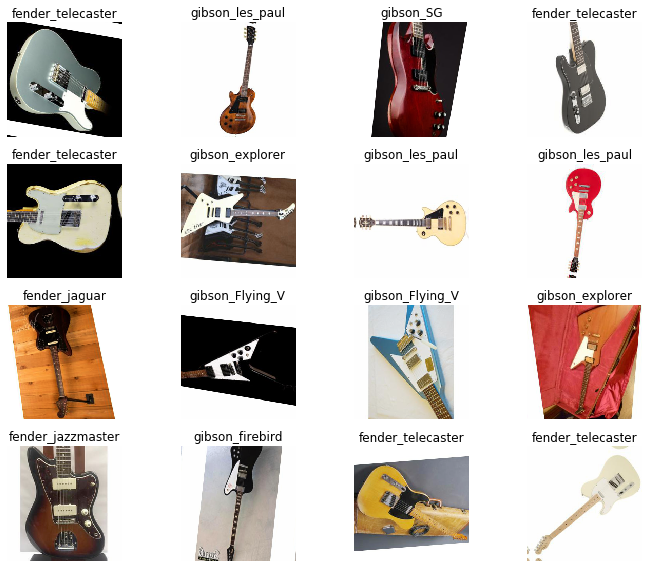

In [8]:
data.show_batch(rows=4, figsize=(10,8))

Mixup Augmentation on a Single image

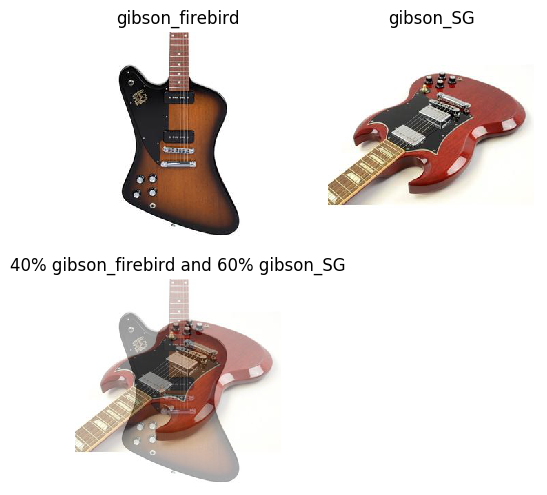

In [9]:
mixed_up=data.train_ds.x[900].data*0.4+data.train_ds.x[2].data*0.6
fig = plt.figure(figsize=(6, 6), dpi=100)
fig.tight_layout()
plt.axis('off')
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(data.train_ds.x[900].data.permute(1,2,0))
ax1.set_axis_off()
ax1.set_title(str(data.train_ds.y[900]))
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(data.train_ds.x[2].data.permute(1,2,0))
ax2.set_axis_off()
ax2.set_title(str(data.train_ds.y[2]))
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(mixed_up.permute(1,2,0))
ax3.set_axis_off()
ax3.set_title("40% "+str(data.train_ds.y[900])+" and 60% "+str(data.train_ds.y[2]))
plt.show()

In [10]:
learn=cnn_learner(data,models.resnet152,metrics=[error_rate,accuracy]).mixup().to_fp16()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 230M/230M [00:04<00:00, 51.6MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


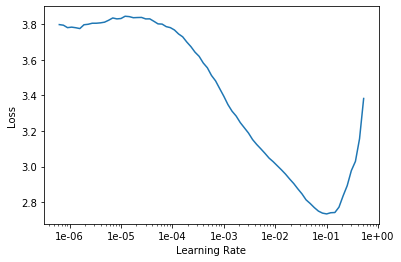

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
lr=1e-3
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.471839,0.777301,0.255882,0.744118,01:19
1,1.920771,0.553955,0.182941,0.817059,01:18
2,1.587376,0.407324,0.122353,0.877647,01:19
3,1.392769,0.372901,0.115294,0.884706,01:18
4,1.291414,0.361376,0.109412,0.890588,01:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


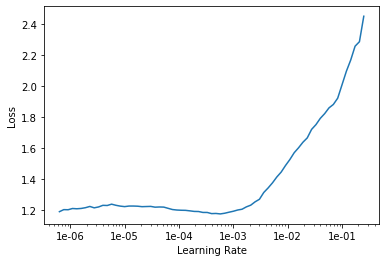

In [13]:
learn.save("iteration1_224_resnet151")

learn.load("iteration1_224_resnet151")

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


In [14]:
lr=1e-4
learn.fit_one_cycle(5, slice(lr, lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.186329,0.263084,0.080588,0.919412,01:34
1,1.126301,0.194479,0.055882,0.944118,01:33
2,1.022389,0.143215,0.040588,0.959412,01:33
3,0.955735,0.132836,0.039412,0.960588,01:33
4,0.922852,0.131062,0.040000,0.960000,01:33


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


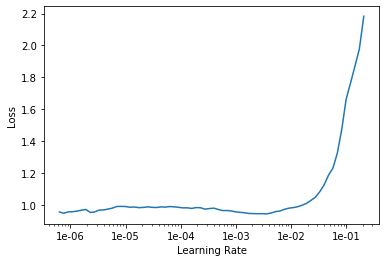

In [15]:
learn.save("iteration2_224_resnet151")

learn.load("iteration2_224_resnet151")


learn.data=get_data(src,image_size=299,batch_size=64)
learn.freeze()
learn = learn.to_fp16()
learn.lr_find()
learn.recorder.plot()

In [16]:
lr=1e-3
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.939433,0.173818,0.051176,0.948824,02:25
1,0.910040,0.135062,0.042941,0.957059,02:23
2,0.860539,0.123314,0.040588,0.959412,02:23
3,0.813065,0.115479,0.033529,0.966471,02:24
4,0.785082,0.108646,0.031176,0.968824,02:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


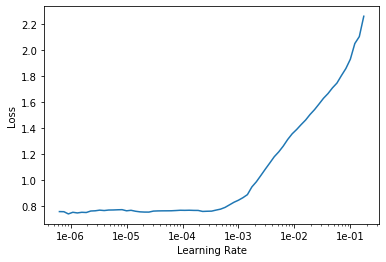

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
lr=1e-4
learn.fit_one_cycle(10, slice(lr, lr/3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.750268,0.096279,0.026471,0.973529,02:51
1,0.757029,0.121564,0.034118,0.965882,02:51
2,0.746554,0.121479,0.032941,0.967059,02:51
3,0.716713,0.093753,0.022941,0.977059,02:50
4,0.684995,0.086569,0.022353,0.977647,02:50
5,0.631780,0.064924,0.017647,0.982353,02:51
6,0.622509,0.064612,0.012941,0.987059,02:51
7,0.592367,0.056924,0.015294,0.984706,02:50
8,0.585165,0.053894,0.014706,0.985294,02:50
9,0.584874,0.054978,0.014706,0.985294,02:50


In [19]:
import numpy as np
log_preds,y=learn.TTA()
probs= np.exp(log_preds)
accuracy(log_preds,y)

tensor(0.9871)

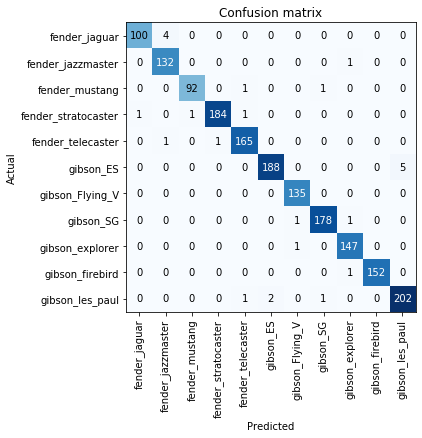

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,6))

In [21]:
display(interp.most_confused(min_val=2))

[('gibson_ES', 'gibson_les_paul', 5),
 ('fender_jaguar', 'fender_jazzmaster', 4),
 ('gibson_les_paul', 'gibson_ES', 2)]

In [0]:
listOfFiles = list()
for (dirpath, dirnames, filenames) in os.walk(path):
  listOfFiles += [os.path.join(dirpath, file) for file in filenames]

In [23]:
len(listOfFiles)

8500

In [0]:
prediction = []
probability = []
for i in listOfFiles:
  img = open_image(i)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())

In [25]:
actual_labels=[listOfFiles[i].split("/")[4] for i in range(len(listOfFiles))]
answer = pd.DataFrame({'Image_Name':listOfFiles,'Actual_label':actual_labels,'Predicted_label':prediction,'Probability':probability})
answer.head()

,Image_Name,Actual_label,Predicted_label,Probability
0,/content/data/guitars/gibson_SG/000942.jpg,gibson_SG,gibson_SG,0.998952
1,/content/data/guitars/gibson_SG/000299.jpg,gibson_SG,gibson_SG,0.999416
2,/content/data/guitars/gibson_SG/001199.jpg,gibson_SG,gibson_SG,0.999574
3,/content/data/guitars/gibson_SG/000360.jpg,gibson_SG,gibson_SG,0.952014
4,/content/data/guitars/gibson_SG/000750.jpg,gibson_SG,gibson_SG,0.999703


In [26]:
print("Number of correctly classified guitars out of 8500:-  ", (answer['Actual_label']==answer['Predicted_label']).sum())
print("Accuracy:-  ",(answer['Actual_label']==answer['Predicted_label']).mean()*100)


Number of correctly classified guitars out of 8500:-   8452
Accuracy:-   99.43529411764706
